In [1]:
!pip install kagglehub
!pip install pennylane


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 196.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 121.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 140.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 118.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import kagglehub
import pandas as pd
import pennylane as qml
from pennylane import numpy as pnp
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA

## Download latest version
path = kagglehub.dataset_download("sameepvani/nasa-nearest-earth-objects")

/usr/local/lib/python3.12/site-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.1 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


100%|█████████████████████████████████████████████████████████████████████| 6.60M/6.60M [00:00<00:00, 66.7MB/s]

Extracting files...


In [3]:

df = pd.read_csv(f"{path}/neo.csv")
df.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [4]:
features = ['est_diameter_min', 'est_diameter_max', 'relative_velocity', 'miss_distance','absolute_magnitude']
target = 'hazardous'

#Reducera dimension

In [5]:
df.iloc[[10,11]]

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
10,54049873,(2020 OT6),0.252671,0.564989,58430.697200,3.833750e+07,Earth,False,20.11,True
11,54099949,(2020 XW4),0.152952,0.342011,64393.928316,7.198311e+07,Earth,False,21.20,False


In [6]:
mask = df[target] == True

In [7]:
# ------------------------- Old data code ------------------------------
# N = 2000
# np.random.seed(123)

# df_true = df[df[target] == True]
# df_false = df[df[target] == False]

# df_subset_true = df_true.iloc[np.random.choice(N, size=N, replace=False)]
# df_subset_false = df_false.iloc[np.random.choice(N, size=N, replace=False)]

# df_subset = pd.concat([df_subset_true, df_subset_false])

# ------------------------- Updated data code -------------------------

N = 10000
np.random.seed(123)

df_true = df[df[target] == True]
df_false = df[df[target] == False]



REPLACE_t = False
REPLACE_f = False

if df_true.shape[0] <= N:
    REPLACE_t = True
if df_false.shape[0] <= N:
    REPLACE_f = True
    
# df_balanced_true = df_true.to_numpy()[np.random.choice(df_true.shape[0], size=N, replace=REPLACE_t)]
# df_balanced_false = df_false.to_numpy()[np.random.choice(df_false.shape[0], size=N, replace=REPLACE_f)]

# df_subset = np.concat([df_balanced_true, df_balanced_false])

df_balanced_true = df_true.iloc[np.random.choice(df_true.shape[0], size=N, replace=REPLACE_t)]
df_balanced_false = df_false.iloc[np.random.choice(df_false.shape[0], size=N, replace=REPLACE_f)]

df_subset = pd.concat([df_balanced_true, df_balanced_false])


In [8]:

from sklearn.model_selection import train_test_split

# Split the dataframe into 80% train and 20% test
train_df, test_df = train_test_split(
    df_subset,
    test_size=0.2,
    random_state=1,
    stratify=df_subset['hazardous']
)

# Optionally display the shapes of the train and test sets
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")



Train shape: (16000, 10)
Test shape: (4000, 10)


In [9]:
from sklearn.model_selection import train_test_split

# Split train_df further into 80% train and 20% validation, stratified on 'hazardous'
train_split_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    random_state=1,
    stratify=train_df['hazardous']
)

# Optionally, print the shapes
print(f"Train split shape: {train_split_df.shape}")
print(f"Validation shape: {val_df.shape}")


Train split shape: (12800, 10)
Validation shape: (3200, 10)


In [10]:
train_split_df[features].head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
65169,0.121494,0.271669,32903.560475,2.869810e+07,21.70
9405,0.120936,0.270421,31980.317837,2.895001e+07,21.71
11655,0.555335,1.241767,93812.350664,1.906140e+07,18.40
21464,0.166938,0.373285,62966.865593,6.822513e+07,21.01
26220,0.006089,0.013616,46216.921837,2.263701e+07,28.20


In [11]:

X_train, Y_train = train_split_df[features].to_numpy(), train_split_df[target].apply(lambda x: int(x)).to_numpy()
X_val, Y_val = val_df[features].to_numpy(), val_df[target].apply(lambda x: int(x)).to_numpy()
X_test, Y_test = test_df[features].to_numpy(), test_df[target].apply(lambda x: int(x)).to_numpy()


In [12]:
y = np.where(Y_train==1, +1, -1)

scaler = StandardScaler()
X_tr = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_te = scaler.transform(X_test)

n_qubits = 4

if n_qubits < 5:
    pca = PCA(n_components=n_qubits).fit(X_tr)
    X_tr_red = pca.transform(X_tr)
    X_val_red = pca.transform(X_val)
    X_te_red = pca.transform(X_te)
else:
    X_tr_red = X_tr
    X_val_red = X_val
    X_te_red = X_te




print("Shapes:", X_tr_red.shape, X_te_red.shape, " (+1 count):", (Y_train==+1).sum(), " (-1 count):", (Y_train==-1).sum())

Shapes: (12800, 4) (4000, 4)  (+1 count): 6400  (-1 count): 0


In [13]:
#n_qubits = 5
SEED = 123

# 1. Define a device with n_qubits wires in analytic mode (shots=None)
# -----YOUR CODE HERE-----
dev = qml.device("default.qubit", wires=n_qubits, shots=None)
# ---YOUR CODE ENDS HERE---

def feature_map_qnn(x, scale=1.0, entangle=True):
    """
    Simple angle-embedding feature map with optional entangling layer.

    x: 1D array-like of length n_qubits (PCA-reduced input)
    scale: rescaling factor for angles
    entangle: if True, apply a CZ ring after single-qubit rotations
    """
    # -----YOUR CODE HERE-----
    wires = list(range(len(x)))
    # 1. Apply AngleEmbedding with rotation="Y" and the given scale
    qml.AngleEmbedding(x*scale, wires=wires, rotation="X")
    qml.AngleEmbedding(x*scale, wires=wires, rotation="Y")

    # 2. If entangle=True, apply a ring of CZ or CNOT gates
    if entangle:
        for i in range(len(wires)-1):
            qml.CZ(wires[i:i+1+1])
        qml.CZ([wires[-1], wires[0]])
    # ---YOUR CODE ENDS HERE---
    return


def variational_ansatz(theta):
    """
    Variational circuit with trainable parameters theta.
    
    theta: parameters with shape (number of layers, number of wires).

    Structure:
    - For each layer:
        - Apply RY rotations on all qubits
        - Apply a ring of CNOTs to entangle the qubits
    """
    n_layers, n_wires = theta.shape
    # -----YOUR CODE HERE-----
    wires = list(range(n_wires))
    for l in range(n_layers):
        qml.AngleEmbedding(theta[l], wires=wires, rotation="X")
        qml.AngleEmbedding(theta[l], wires=wires, rotation="Y")
        if l != n_layers-1:
            for i in range(len(wires)-1):
                qml.CZ(wires[i:i+1+1])
            qml.CZ([wires[-1], wires[0]])
    # ---YOUR CODE ENDS HERE---
    return

# print(qml.draw(feature_map_qnn)(Xtr_red[0]))
# dev.wires

In [14]:
# Task 3: QNode and QNN classifier with PyTorch

# Decide a theta shape, e.g. for L layers and n_qubits:
# theta_shape = (n_layers, n_qubits)
# You may choose a different layout if you like.
n_layers = 2
theta_shape = (n_layers, n_qubits)

# @qml.qnode(dev, interface="torch", diff_method="parameter-shift")
# def qnn_circuit(x, theta):
#     """
#     Quantum node for a single input sample.

#     x: 1D tensor with n_qubits features
#     theta: trainable parameters for the ansatz
#     """
#     # -----YOUR CODE HERE-----
#     feature_map_qnn(x)
#     variational_ansatz(theta)
#     _ , n_wires = theta.shape
#     return qml.expval(qml.sum(*[qml.PauliZ(i) for i in range(n_wires)])) / n_wires
#     # ---YOUR CODE ENDS HERE---
    
@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def qnn_circuit(x, theta):
    feature_map_qnn(x)
    variational_ansatz(theta)
    _, n_wires = theta.shape
    # Scale the observable itself (1/n * sum of Z_i)
    #obs = qml.sum(qml.PauliZ(0) + qml.PauliZ(n_wires-1))/2 #(1 / n_wires) * qml.sum(*[qml.PauliZ(i) for i in range(n_wires)])
    obs = qml.PauliZ(0)
    for i in range(1, n_qubits):
        obs = obs @ qml.PauliZ(i)
    return qml.expval(obs)

class QNNClassifier(nn.Module):
    def __init__(self, theta_shape):
        super().__init__()
        # Initialize trainable parameters theta as a PyTorch Parameter
        self.theta = nn.Parameter(torch.randn(theta_shape) * 0.01)
        nn.init.xavier_normal_(self.theta)

    def forward(self, x):
        """
        x: tensor of shape (batch_size, n_qubits)
        returns: probabilities in [0,1] of shape (batch_size, 1)
        """
        # -----YOUR CODE HERE-----
        # 1. Ensure x has a batch dimension
        # 2. For each sample in the batch, call qnn_circuit(sample, self.theta)
        # 3. Stack expectation values into a tensor
        # 4. Map from [-1,1] to [0,1]
        # 5. Return p with shape (batch_size, 1)
        if len(x.shape) == 1:
            x = x.unsqueeze(0)
        assert len(x.shape) == 2
        batch_size, n_qubits = x.shape
        exps = []
        for i in range(batch_size):
            exps.append(qnn_circuit(x[i], self.theta))

        output = (torch.stack(exps) + 1)/2
        return output.unsqueeze(-1)
        
        # ---YOUR CODE ENDS HERE---


# Instantiate model and move to Torch device
device_torch = "cuda" if torch.cuda.is_available() else "cpu"
model = QNNClassifier(theta_shape).to(device_torch)
print(model)

from pennylane import draw

# Draw the QNN circuit for a random x and theta
import matplotlib.pyplot as plt

# Random sample input and theta for visualization
x_example = torch.randn(theta_shape[1], dtype=torch.double)
theta_example = torch.randn(theta_shape, dtype=torch.double)

print(qml.draw(qnn_circuit)(x_example, theta_example))




QNNClassifier()
0: ─╭AngleEmbedding(M0)─╭AngleEmbedding(M0)─╭●───────╭Z─╭AngleEmbedding(M1)─╭AngleEmbedding(M1) ···
1: ─├AngleEmbedding(M0)─├AngleEmbedding(M0)─╰Z─╭●────│──├AngleEmbedding(M1)─├AngleEmbedding(M1) ···
2: ─├AngleEmbedding(M0)─├AngleEmbedding(M0)────╰Z─╭●─│──├AngleEmbedding(M1)─├AngleEmbedding(M1) ···
3: ─╰AngleEmbedding(M0)─╰AngleEmbedding(M0)───────╰Z─╰●─╰AngleEmbedding(M1)─╰AngleEmbedding(M1) ···

0: ··· ─╭●───────╭Z─╭AngleEmbedding(M2)─╭AngleEmbedding(M2)─┤ ╭<Z@Z@Z@Z>
1: ··· ─╰Z─╭●────│──├AngleEmbedding(M2)─├AngleEmbedding(M2)─┤ ├<Z@Z@Z@Z>
2: ··· ────╰Z─╭●─│──├AngleEmbedding(M2)─├AngleEmbedding(M2)─┤ ├<Z@Z@Z@Z>
3: ··· ───────╰Z─╰●─╰AngleEmbedding(M2)─╰AngleEmbedding(M2)─┤ ╰<Z@Z@Z@Z>

M0 = 
tensor([-0.5786,  0.1941, -0.6162,  1.5334], dtype=torch.float64)
M1 = 
tensor([-0.1769, -0.5946,  0.7310, -0.1607], dtype=torch.float64)
M2 = 
tensor([ 1.3118, -0.4349, -0.3841, -1.0558], dtype=torch.float64)


In [15]:
batch_size = 64

train_ds = TensorDataset(
    torch.tensor(X_tr_red, dtype=torch.double),
    torch.tensor(Y_train, dtype=torch.double).unsqueeze(1),
)
val_ds = TensorDataset(
    torch.tensor(X_val_red, dtype=torch.double),
    torch.tensor(Y_val, dtype=torch.double).unsqueeze(1),
)
test_ds = TensorDataset(
    torch.tensor(X_te_red, dtype=torch.double),
    torch.tensor(Y_test, dtype=torch.double).unsqueeze(1),
)



train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)



In [16]:
epoch_losses = []

In [28]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

n_epochs = 1

history = {"loss": [], "val_loss": []}

for epoch in range(1, n_epochs + 1):
    model.train()
    epoch_loss = 0.0

    for xb, yb in tqdm(train_loader):
        xb = xb.to(device_torch)
        yb = yb.to(device_torch)

        # -----YOUR CODE HERE-----
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        # ---YOUR CODE ENDS HERE---

        epoch_loss += loss.item() * xb.size(0)
    epoch_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in tqdm(val_loader):
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_loader.dataset)

    history["loss"].append(epoch_loss)
    history["val_loss"].append(val_loss)
    print(f"Epoch {epoch:02d}/{n_epochs} - loss: {epoch_loss:.4f} - val_loss: {val_loss:.4f}")
epoch_losses.append(epoch_loss)

100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.25it/s]

Epoch 01/1 - loss: 0.4787 - val_loss: 0.4872


In [29]:
epoch_losses

[0.49925548941295916,
 0.47841233041730363,
 0.47879670568121496,
 0.47868490296393984]

In [19]:
# # Transfer learning: reuse trained weights when increasing the number of layers.
# # NOTE: theta_shape is (n_layers, n_qubits) (see how you set theta_shape above).

# new_n_layers = model.theta.shape[0] + 1  # add one extra layer
# model2 = QNNClassifier((new_n_layers, n_qubits)).to(device_torch)

# # Make sure dtype/device match (helps avoid copy / qnode dtype issues)
# model2 = model2.to(device=model.theta.device, dtype=model.theta.dtype)

# with torch.no_grad():
#     # Copy all existing layers (same n_qubits)
#     model2.theta[: model.theta.shape[0], :].copy_(model.theta)

#     # Initialize the new (extra) layer (optional)
#     if model2.theta.shape[0] > model.theta.shape[0]:
#         torch.nn.init.normal_(model2.theta[model.theta.shape[0] :], mean=0.0, std=0.01)

# print("model.theta:", tuple(model.theta.shape), "-> model2.theta:", tuple(model2.theta.shape))

In [20]:
# criterion = nn.BCELoss()
# optimizer = torch.optim.Adam(model2.parameters(), lr=0.2)

# n_epochs = 4

# history2 = {"loss": [], "val_loss": []}

# for epoch in range(1, n_epochs + 1):
#     model2.train()
#     epoch_loss = 0.0

#     for xb, yb in train_loader:
#         xb = xb.to(device_torch)
#         yb = yb.to(device_torch)

#         optimizer.zero_grad()
#         out = model2(xb)
#         loss = criterion(out, yb)
#         loss.backward()
#         optimizer.step()

#         epoch_loss += loss.item() * xb.size(0)
#     epoch_loss /= len(train_loader.dataset)

#     model2.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         for xb, yb in val_loader:
#             preds = model2(xb)
#             loss = criterion(preds, yb)
#             val_loss += loss.item() * xb.size(0)
#     val_loss /= len(val_loader.dataset)

#     history2["loss"].append(epoch_loss)
#     history2["val_loss"].append(val_loss)
#     print(f"[model2] Epoch {epoch:02d}/{n_epochs} - loss: {epoch_loss:.4f} - val_loss: {val_loss:.4f}")

100%|████████████████████████████████████████████████████████████████████████| 125/125 [00:29<00:00,  4.27it/s]

Test accuracy: 0.806
Confusion matrix [[TN, FP], [FN, TP]]:
[[1509  491]
 [ 285 1715]]


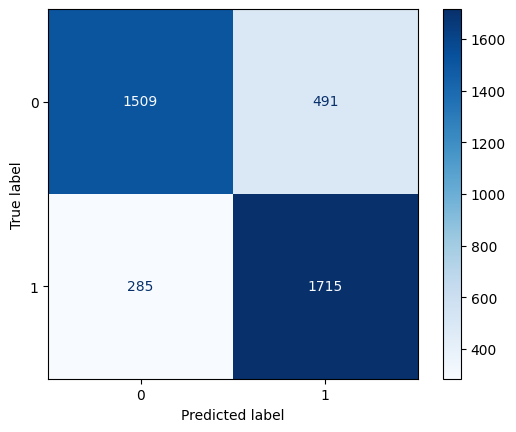

              precision    recall  f1-score   support

           0       0.84      0.75      0.80      2000
           1       0.78      0.86      0.82      2000

    accuracy                           0.81      4000
   macro avg       0.81      0.81      0.81      4000
weighted avg       0.81      0.81      0.81      4000

ROC-AUC: 0.856


<Figure size 640x480 with 0 Axes>

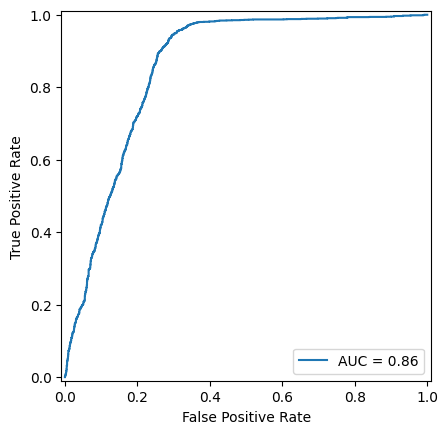

In [30]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)
# Evaluation on test set

model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for xb, yb in tqdm(test_loader):
        xb = xb.to(device_torch)
        yb = yb.to(device_torch)

        probs = model(xb)  # (batch_size, 1)
        all_probs.append(probs.cpu())
        all_labels.append(yb.cpu())

all_probs = torch.cat(all_probs, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# Convert probabilities to class predictions
y_pred = (all_probs >= 0.5).int()
y_true = all_labels.int()

acc = accuracy_score(y_true.numpy(), y_pred.numpy())
cm = confusion_matrix(y_true.numpy(), y_pred.numpy())

print(f"Test accuracy: {acc:.3f}")
print("Confusion matrix [[TN, FP], [FN, TP]]:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")
plt.show()

print(classification_report(y_true.numpy(), y_pred.numpy()))


from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score

plt.figure()
# Compute ROC curve and ROC area for model
fpr, tpr, thresholds = roc_curve(y_true.numpy(), all_probs.numpy())
roc_auc = roc_auc_score(y_true.numpy(), all_probs.numpy())

print(f"ROC-AUC: {roc_auc:.3f}")

roc_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_disp.plot()
plt.show()


In [22]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)
# Evaluation on test set

model2.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device_torch)
        yb = yb.to(device_torch)

        probs = model2(xb)  # (batch_size, 1)
        all_probs.append(probs.cpu())
        all_labels.append(yb.cpu())

all_probs = torch.cat(all_probs, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# Convert probabilities to class predictions
y_pred = (all_probs >= 0.5).int()
y_true = all_labels.int()

acc = accuracy_score(y_true.numpy(), y_pred.numpy())
cm = confusion_matrix(y_true.numpy(), y_pred.numpy())

print(f"Test accuracy: {acc:.3f}")
print("Confusion matrix [[TN, FP], [FN, TP]]:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")
plt.show()

print(classification_report(y_true.numpy(), y_pred.numpy()))


NameError: name 'model2' is not defined